Técnicas de machine learning aplicadas a la predicción de precios de stocks. 

In [47]:
# Manipulación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Plots

# Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

#Manejo de archivos
import os
import tempfile
import shutil

La clase Data encapsula un dataframe con todos los datos históricos de los stocks. 
Permite además crear un conjunto de datos (x,y), donde y es el stock que quiere predecirse.
Los archivos csv deben estar en la carpeta /data/originales.

In [48]:
class Data:
    "Recibe una lista de nombres archivos csv de stocks y administra sus datos."
    __dir_data = "data"
    
    def __init__(self,stock_names,fecha_comienzo,fecha_fin):
        self.stock_names = stock_names
        self.fecha_comienzo = fecha_comienzo
        self.fecha_fin = fecha_fin
        
        stockdata = self.__get_stocks()
        
        # Seleccionar los datos dentro del rango de fechas
        self.data = pd.DataFrame(pd.date_range(start=self.fecha_comienzo, end=self.fecha_fin, freq='D'),columns=['Date'])
        self.data.set_index('Date', inplace=True)
        self.data = pd.merge(self.data, stockdata,  how='left', left_index=True, right_index=True)
        self.data.replace('-',np.nan,inplace=True) 
        self.data = self.data.interpolate().ffill().fillna(0) #Completar campos faltantes e interpolar valores
    
        # Guardar Datos
        if not os.path.exists(self.__dir_data):
            os.makedirs(self.__dir_data)
        path = self.__dir_data + "/" + 'data' + '.csv'
        self.data.to_csv(path, index=True)
        print('Datos recolectados, archivo: ' + path)
    
    def __get_stocks(self):    
        "Arma un dataframe con todos los datos de los archivos de stocks"
        stock_dataframe =  pd.DataFrame()
        
        for stock in self.stock_names:
            df = pd.read_csv('data/original/' + stock + '.csv')

            df.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
            df.rename(columns={'Close': stock}, inplace=True)
            df.set_index('Date', inplace=True)
    
            stock_dataframe = pd.concat([stock_dataframe, df], axis=1)

            print('Stock procesado: ' + stock)
        
        stock_dataframe.index.name = 'Date'
        
        return stock_dataframe
    
    def plot(self):
        "Graficar los datos de la instancia de datos"
        plt.figure(figsize=(20,5))
        plt.title("Stock Indexes", fontsize=25)
        for stock in np.arange(0, len(self.data.columns), 1):
            plt.plot(self.data[self.data.columns[stock]], label=self.data.columns[stock])    
        plt.legend()
        plt.show()
        
    def create_dataset(self,stock,fecha_comienzo,fecha_fin):
        """
        Convierte el conjunto de datos en dos conjuntos X e Y (input/output)
 
        :param stock: nombre de la columna en el dataframe del target
        :returns: conjuntos X e Y como numpy array
        """
        # Seleccionar los datos dentro del rango de fechas
        dataset = pd.DataFrame(pd.date_range(start=fecha_comienzo, end=fecha_fin, freq='D'),columns=['Date'])
        dataset.set_index('Date', inplace=True)
        dataset = pd.merge(dataset, dm.data,  how='left', left_index=True, right_index=True)
        dataset = dataset.interpolate().ffill().fillna(0) #Completar campos faltantes e interpolar los valores
        
        pos_y = dataset.columns.get_loc(stock) # Obtener columna correspondiente al stock a predecir
        dataset = dataset.values
        x = np.asarray(dataset)
        y = np.asarray(dataset[:,pos_y])
        
        return {'x': x, 'y': y, 'stock':stock}

La clase Predictor procesa los datos del dataset, construyendo un conjunto de entrenamiento y de testeo, según una cantidad de días de ventana (días hacia atrás que se toman como input) y un día a predecir en el futuro. Este conjunto se normaliza (entre 0 y 1) para agilizar el entrenamiento de la red neuronal.
La red neuronal es una RNN (recurrente), utilizando una capa LSTM, con n neuronas (pasadas como parámetro).
Después de entrenar la red sobre el conjunto de entrenamiento, se la testea sobre el conjunto de testeo, que todavía no fue visto por la misma. El testeo consiste en una predicción (y de predicción) que se compara con los valores reales (y real) para el conjunto de entrada de testeo. A partir del entrenamiento se obtiene un error (que es un indicador de la eficiencia del modelo), y a partir del testeo se obtiene un valor RMSE de error comparado con los valores reales.
Las predicciones y el historial de entrenamiento se guardan en la carpeta /predicciones/*nombre_stock*/*dataset_name*, donde dataset_name = 'f' + dia futuro a predecir + 'v' + ventana + 'n' + neuronas + 'e' + epochs. 
Entonces, por ejemplo, para una configuración de una red de 4 neuronas, 20 epochs, 7 días de ventana y que predice el séptimo día del stock ^IXIC, los archivos de predicción estarán en /prediccion/^IXIC/f7v7n4e20/predicciones.csv. El historial de entrenamiento estará en la misma carpeta y se llamará 'train_history.csv'.

In [49]:
class Predictor:    
    __dir_predicciones = "predicciones"
    
    def __init__(self,dataset):
        """
        Constructor de la clase Predictor (preprocesador, entrenamiento y prediccion)
        
        :param dataset: un conjunto de datos de la clase Data 
        """
        self.x = np.copy(dataset['x'])
        self.y = np.copy(dataset['y'])
        self.stock = dataset['stock']
        print("New Predictor")       
          
    def __data_preprocessing(self,test_size,window_size=1,dia_futuro=1):
        # Dividir el conjunto de x e y en conjuntos de training y testing
        # La y se corre dia_futuro-1 porque el generator del predictor asigna cada sample de x con un valor de y +1
        # (es decir, que genera un target de un dia a futuro)
        train_x = self.x[0:len(self.x)-test_size,:]
        train_y = self.y[(dia_futuro-1):len(self.y)-test_size+(dia_futuro-1)]
        train_y = train_y.reshape(-1,1)
        test_x  = self.x[len(self.x)-test_size:len(self.x)-(dia_futuro-1),:]
        test_y  = self.y[len(self.y)-test_size+(dia_futuro-1):]
        test_y = test_y.reshape(-1,1)
        self.real_price = test_y[window_size:]
        
        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
        self.__scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
        train_x_scaled = self.__scalerX.transform(train_x)
        test_x_scaled = self.__scalerX.transform(test_x)
        self.__scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y)
        train_y_scaled = self.__scalerY.transform(train_y)
        test_y_scaled = self.__scalerY.transform(test_y)
    
        '''
        TimeseriesGenerator crea una secuencia de samples, cada una de longitud *length*, 
        tomadas de a *sampling_rate* timesteps. 
        El end_index es la ultima posición que se va a tomar en los datos (tiene que ser +1 que la que se quiere)
        El start_index es la primera posición desde la que se van a tomar los datos.
        '''
        validation_split = 0.8        
        batch_s = 15
        self.__training_sequence = TimeseriesGenerator(train_x_scaled, train_y_scaled,
                               length=window_size, sampling_rate=1, 
                                end_index=int(len(train_x)*validation_split),
                               batch_size=batch_s)
        self.__validation_sequence = TimeseriesGenerator(train_x_scaled, train_y_scaled,
                                       length=window_size, sampling_rate=1, 
                                        start_index=int(len(train_x)*validation_split), end_index=len(train_x),
                                       batch_size=batch_s)
        self.__testing_sequence = TimeseriesGenerator(test_x_scaled, test_y_scaled,
                                       length=window_size, sampling_rate=1, 
                                        end_index=len(test_x),
                                       batch_size=1)
        
    def __red_neuronas(self,neuronas,epochs,verbose):
        "Arma una red neuronal RNN de una capa LSTM con la cantidad de neuronas pasadas por parámetro"
        self.model = Sequential()
        self.model.add(LSTM(units = neuronas, dropout=0, 
                       input_shape=(self.__training_sequence[0][0].shape[1], #window_size
                                    self.__training_sequence[0][0].shape[2]))) #features
        self.model.add(Dense(units = 1, activation = 'linear'))
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

        self.history = self.model.fit_generator(self.__training_sequence,
                                                validation_data=self.__validation_sequence,
                                                epochs=epochs,verbose=verbose)        
    
    def __predict(self):
        "Realiza la predicción sobre el conjunto de testing"
        predicted = self.model.predict_generator(self.__testing_sequence)
        predicted = predicted.reshape(-1,1)
        predicted = self.__scalerY.inverse_transform(predicted)

        return predicted
    
    def entrenar_predecir(self,test_size,window_size,dia_futuro,neuronas,epochs,verbose=1,visualizar=1): 
        "Preprocesa los datos, construye la red neuronal, la entrena, y la testea con el conjunto de testeo"
        self.__data_preprocessing(test_size=test_size,window_size=window_size,dia_futuro=dia_futuro)
        print("Datos Preprocesados. Entrenando...")
        self.__red_neuronas(neuronas=neuronas,epochs=epochs,verbose=verbose)
        predicted = self.__predict()
              
        # Armar dataframes de predicciones e historial de entrenamiento
        predicciones = pd.DataFrame() # Dataframe de predicciones
        training_history = pd.DataFrame() # Dataframe de entrenamiento
        dataset_name = 'f' + str(dia_futuro) + 'v' + str(window_size) + 'n' + str(neuronas) + 'e' + str(epochs)
        predicciones = pd.concat([predicciones, pd.DataFrame(data=predicted, columns=[dataset_name])], axis=1)
        predicciones = pd.concat([predicciones, pd.DataFrame(data=self.real_price, columns=['Y'])], axis=1)
        training_history = pd.concat([training_history, pd.DataFrame(data=self.history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
        training_history = pd.concat([training_history, pd.DataFrame(data=self.history.history['val_loss'], columns=[dataset_name + 'val_loss'])], axis=1)

        # Guardar datos        
        if not os.path.exists(self.__dir_predicciones):
            os.makedirs(self.__dir_predicciones) # Crear carpeta de predicciones
        datasetfolder = self.__dir_predicciones + "/"  + self.stock + "/"+ dataset_name
        if (os.path.exists(datasetfolder)):
            tmp = tempfile.mktemp(dir=os.path.dirname(datasetfolder))
            shutil.move(datasetfolder, tmp) # Mover el dir a una ubicacion temporal
            shutil.rmtree(tmp) # Eliminar la carpeta que existía
        os.makedirs(datasetfolder)   
        
        predicciones.to_csv(datasetfolder + '/predicciones.csv', index=False)
        predicciones.to_json(datasetfolder + '/predicciones.json',orient="columns")
        print('Predicciones guardadas en carpeta: ' + datasetfolder)

        training_history.to_csv(datasetfolder +  '/train_history.csv', index=False)
        training_history.to_json(datasetfolder + '/train_history.json',orient="columns")
        print('Entrenamiento guardado en carpeta: ' + datasetfolder)
        
        # Diccionario a devolver con toda la información sobre la instancia de predicción.
        p = {'predicciones':predicciones, 
                'training_history':training_history,
                'neuronas':neuronas,
                'epochs':epochs,
                'test_size':test_size,
                'dataset_name':dataset_name,
                'window':window_size,
                'dia_futuro':dia_futuro } 
        
        if visualizar:
            self.visualizar(p)
        
        return p
    
    def visualizar(self,prediccion):
        "Visualización de resultados de entrenar_predecir"
        #Grafico de entrenamiento
        plt.figure(figsize=(20,5))
        plt.plot(prediccion['training_history'][prediccion['training_history'].columns[0]], label='loss')
        plt.plot(prediccion['training_history'][prediccion['training_history'].columns[1]], label='val_loss')
        plt.title("Historial de entrenamiento", fontsize=40)
        plt.legend()
        plt.grid(color='grey', linestyle='-', linewidth=0.5)
        plt.show()    

        # El precio real es la ultima columna del dataframe
        val_prediccion = prediccion['predicciones'][prediccion['predicciones'].columns[0]]
        val_real = prediccion['predicciones']['Y']
        rmse = sqrt(mean_squared_error(val_real, val_prediccion))
        print("RMSE: " + str(rmse))
        
        plt.figure(figsize=(20,10))
        plt.plot(val_prediccion, color = (1, 0, 0), label = str(prediccion['dataset_name']))
        plt.plot(val_real, color = (0, 0, 1), label = 'Precio Real')
        plt.title("Predicción " + self.stock + "(" + str(prediccion['dia_futuro']) + " dias en el futuro)", fontsize=40)
        plt.legend()
        plt.grid(color='grey', linestyle='-', linewidth=0.5)
        plt.show()

Se obtienen datos históricos de stocks de https://finance.yahoo.com/, guardados en la carpeta /data/originales como archivos csv. Se elige un período de tiempo en el conjunto de datos sobre el que se entrenará y testeará la red, y se realizarán varias simulaciones:
    - Variando el stock a predecir
    - Variando los días de ventana, el día futuro a predecir y la cantidad de neuronas de la capa LSTM.

Stock procesado: ^IXIC
Stock procesado: ^RUT
Stock procesado: ^DJI
Stock procesado: ^GSPC
Datos recolectados, archivo: data/data.csv
                  ^IXIC        ^RUT          ^DJI        ^GSPC
Date                                                          
2012-01-01     0.000000    0.000000      0.000000     0.000000
2012-01-02     0.000000    0.000000      0.000000     0.000000
2012-01-03  2648.719971  752.280029  12397.379883  1277.060059
2012-01-04  2648.360107  747.280029  12418.419922  1277.300049
2012-01-05  2669.860107  752.289978  12415.700195  1281.060059


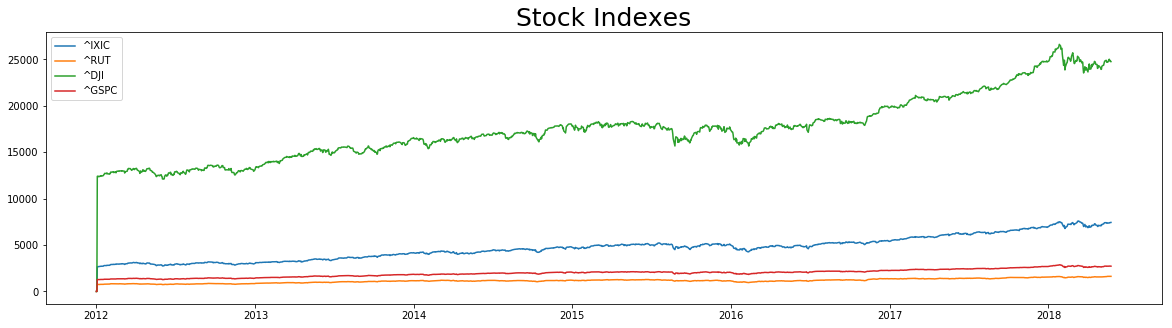

New Predictor
Datos Preprocesados. Entrenando...
Predicciones guardadas en carpeta: predicciones/^IXIC/f1v1n2e20
Entrenamiento guardado en carpeta: predicciones/^IXIC/f1v1n2e20


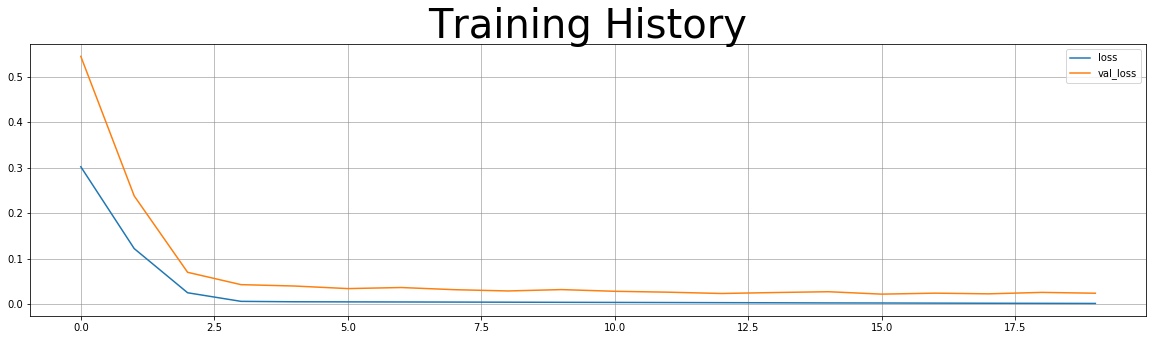

RMSE: 1666.2346280108204


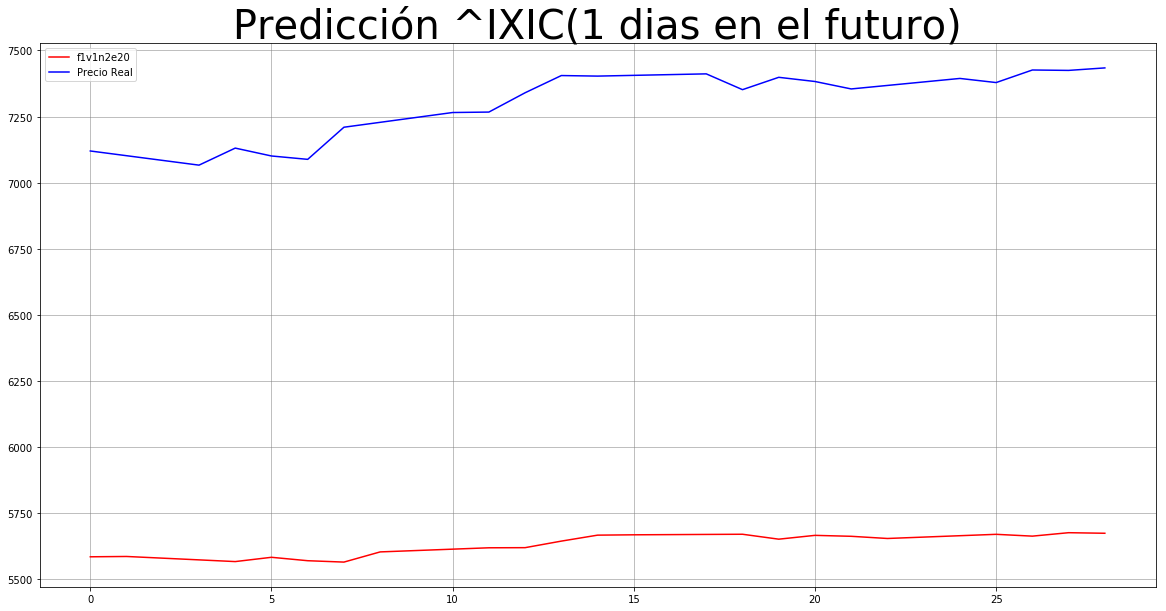

New Predictor
Datos Preprocesados. Entrenando...


KeyboardInterrupt: 

In [51]:
stockindex_names = ['^IXIC','^RUT','^DJI','^GSPC']
ventana = [1,2,7,15]
neuronas = [2,4]
futuro = [1,2,7,15]

# DataManager
dm = Data(stock_names=stockindex_names,fecha_comienzo='2012-01-01', fecha_fin='2018-05-25')
print(dm.data.head())
dm.plot()

for stock in stockindex_names:
    dataset = dm.create_dataset(stock,fecha_comienzo=dm.fecha_comienzo,fecha_fin=dm.fecha_fin)
    for f in futuro:
        for v in ventana:
            for n in neuronas:
                predictor = Predictor(dataset)
                p = predictor.entrenar_predecir(test_size=30,window_size=v,dia_futuro=f,neuronas=n,epochs=20,visualizar=1,verbose=0)

Se visualiza el error de cada configuración y el RMSE entre los valores predecidos y los valores reales.

In [ ]:
def visualizar_errores(moneda,ventana,futuro,neuronas,epochs):
        for f in futuro:        
            plt.figure(figsize=(20,5*len(ventana)*len(neuronas)*len(epochs)))
            i = 1
            rmses_y = []
            rmses_x = []
            for v in ventana:  
                    for n in neuronas:
                            file = 'f' + str(f) + 'v' + str(v) + 'n' + str(n)  + 'e' + str(epochs)
                            prediccion = pd.read_csv('predicciones/' + moneda + '/' + file  + '/predicciones.csv')
                            rmse = sqrt(mean_squared_error(prediccion[prediccion.columns[1]], prediccion[prediccion.columns[0]]))
                            rmses_y.append(rmse)
                            rmses_x.append(file)  
                            plt.subplot(len(ventana)*len(neuronas)*len(epochs), 2, i)
                            training = pd.read_csv('predicciones/' + moneda + '/' + file + '/train_history.csv')
                            plt.plot(training[training.columns[0]], label='loss')
                            plt.plot(training[training.columns[1]], label='val_loss')
                            plt.title(file, fontsize=40)
                            plt.legend()
                            plt.grid(color='grey', linestyle='-', linewidth=0.5)
                            i+=1
            plt.show()    
            #RMSE
            width = 1/1.5
            plt.figure(figsize=(20,5))
            plt.bar(rmses_x, rmses_y, width)
            plt.xticks(rotation=20)
            plt.title("RMSE")
            plt.show()

for stock in stockindex_names:
    visualizar_errores(stock,ventana,futuro,neuronas,20)